In [67]:
import numpy as np
import osmnx as ox
import networkx as nx 
import pandas as pd 
import matplotlib.pyplot as plt
import copy 
%matplotlib inline

## Download graph

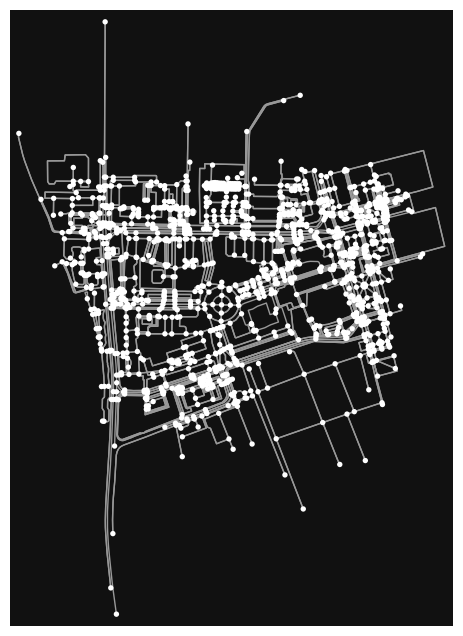

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [71]:

# Specify the path to your .osm file
osm_file_path = "/home/igoreshka/Downloads/map (2)"

# Load the road network from the .osm file
graph = ox.graph_from_xml(osm_file_path, simplify=True)

# Visualize the road network
ox.plot_graph(ox.project_graph(graph))

## Graph description

In [ ]:
for u, v, key, edge_data in graph.edges(keys=True, data=True):
    print(edge_data)
for node in graph.nodes():
    print(graph.nodes[node])
    

In [90]:
for u, v, key, edge_data in graph.edges(keys=True, data=True):
    print(edge_data.keys())


dict_keys(['osmid', 'oneway', 'highway', 'access', 'reversed', 'length'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length'])
dict_keys(['osmid', 'oneway', 'highway', 'access', 'reversed', 'length'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length'])
dict_keys(['osmid', 'oneway', 'highway', 'access', 'reversed', 'length'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length'])
dict_keys(['osmid', 'oneway', 'highway', 'access', 'reversed', 'length'])
dict_keys(['osmid', 'oneway', 'highway', 'service', 'access', 'reversed', 'length', 'geometry'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length'])
dict_keys(['osmid', 'oneway', 'highway', 'service', 'access', 'reversed', 'length', 'geometry'])
dict_keys(['osmid', 'highway', 'oneway', 'reversed', 'length']

## Delete small roads

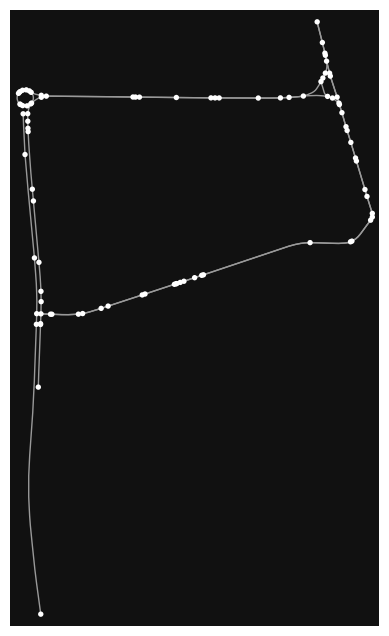

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [93]:
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

result_graph = copy.deepcopy(graph)

# Какие типы дорог хотим оставить

need_keys = ['lanes']
highway_types = ["motorway", "trunk", "primary", "secondary",'service']

edges_to_remove = []
for u, v, key, edge_data in result_graph.edges(keys=True, data=True):
    # KEYS FILTER
    for need_key in need_keys :
        if need_key not in edge_data.keys() :
            edges_to_remove.append((u, v, key))
            break
    # HIGHWAY FILTER
    if 'highway' not in edge_data.keys() :
        edges_to_remove.append((u, v, key))
    else :
        if type(edge_data['highway']) == type(""):
            if edge_data['highway'] not in highway_types :
                edges_to_remove.append((u, v, key))
        else :
            for highway_type in edge_data['highway'] :
                if highway_type not in highway_types :
                    edges_to_remove.append((u, v, key))
                    break
for u, v, key in set(edges_to_remove):
    result_graph.remove_edge(u, v, key)

# Получение списка вершин без ребер
isolated_nodes = [node for node in result_graph.nodes() if result_graph.degree(node) == 0]

# Удаление вершин без ребер
result_graph.remove_nodes_from(isolated_nodes)

ox.plot_graph(ox.project_graph(result_graph))

## Convert result graph to dataframe

In [87]:
df = pd.DataFrame(result_graph.edges(data=True),columns=['Init Node' , 'Term Node' , 'data'])
df['data'][22]

{'osmid': 544655999,
 'highway': 'service',
 'oneway': False,
 'reversed': False,
 'length': 30.329,
 'geometry': <LINESTRING (37.499 55.939, 37.499 55.939, 37.499 55.939, 37.499 55.939, 37....>}

In [88]:
df = pd.DataFrame(result_graph.edges(data=True),columns=['Init Node' , 'Term Node' , 'data'])

df['osmid'] = df['data'].apply(lambda x: x['osmid'])
df['highway'] = df['data'].apply(lambda x: x['highway'])
df['length'] = df['data'].apply(lambda x: x['length'])
df['reversed'] = df['data'].apply(lambda x: x['reversed'])
df['oneway'] = df['data'].apply(lambda x: x['oneway'])
# df['access'] = df['data'].apply(lambda x: x['access'])


# df.drop('data', axis=1, inplace=True)

df.head()

,Init Node,Term Node,data,osmid,highway,length,reversed,oneway
0,10741047307,10741047311,"{'osmid': 1154967458, 'oneway': True, 'highway...",1154967458,service,17.976,False,True
1,10741047308,10741030794,"{'osmid': 32488015, 'highway': 'service', 'one...",32488015,service,4.977,False,False
2,10741047308,3226356476,"{'osmid': 32488015, 'highway': 'service', 'one...",32488015,service,45.891,True,False
3,10741047309,10741047308,"{'osmid': 1154967458, 'oneway': True, 'highway...",1154967458,service,5.282,False,True
4,10741047310,10741030794,"{'osmid': 544635220, 'oneway': True, 'highway'...",544635220,service,5.204,False,True


In [35]:

# nodes = pd.DataFrame(columns=['x' , 'y'])

# nodes_tntp = pd.DataFrame()
# nodes_tntp['Node'] = nodes.index
# nodes_tntp['x'] = nodes['x'].values
# nodes_tntp['y'] = nodes['y'].values

# # Create the .tntp format DataFrame for edges

# # print(edges.__dict__)



# edges_tntp = pd.DataFrame()

# edges_tntp = pd.DataFrame(columns=['key', 'Init Node', 'Term Node', 'Capacity', 'Length', 'Free Flow Time', 'B', 'Speed Limit'])

# # # Заполнение значений в новом фрейме edges_tntp
# edges_tntp['key'] = edges.index.get_level_values(0)
# edges_tntp['Init Node'] = edges.index.get_level_values(1)
# edges_tntp['Term Node'] = edges.index.get_level_values(2)
# # edges_tntp['Capacity'] = edges['lanes'].values
# edges_tntp['Length'] = edges['length'].values
# edges_tntp['Free Flow Time'] = 0  # Здесь можно указать нужное значение
# edges_tntp['B'] = 0
# # edges_tntp['Power'] = edges['power'].values  # Здесь можно указать нужное поле
# edges_tntp['Speed Limit'] = edges['maxspeed'].values

# # # # Вывод нового фрейма edges_tntp
# # print(edges_tntp)


# # # # Save the .tntp format DataFrames to files
# nodes_tntp.to_csv("nodes.tntp", sep="\t", index=False)
# edges_tntp.to_csv("edges.tntp", sep="\t", index=False)

KeyError: 'maxspeed'